In [ ]:
!pip install tensorflow
!pip install tf_keras==2.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-

In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
USER_PATH = r"/kaggle/input/brain-tumor-mri-dataset"
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
image_size = (255, 255)

# Training batch size
batch_size = 16

# # Getting data using above function
# train_paths, train_labels = get_data_labels(train_dir)
# test_paths, test_labels = get_data_labels(test_dir)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (255, 255, 3)
Epochs: 40
Batch size: 16
Steps Per Epoch: 357
Validation steps: 81


In [ ]:
from tensorflow.keras.optimizers import Adam, Adamax
model = models.Sequential([

    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="softmax")
])

model.summary()


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 81, 81, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps)

Epoch 1/40


I0000 00:00:1714303594.146245     112 service.cc:145] XLA service 0x7e5b40769860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714303594.146290     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1714303594.274670     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 [==============================] - 139s 318ms/step - loss: 0.8733 - accuracy: 0.6169 - val_loss: 0.7202 - val_accuracy: 0.7284
Epoch 2/40
357/357 [==============================] - 94s 263ms/step - loss: 0.5885 - accuracy: 0.7673 - val_loss: 0.6512 - val_accuracy: 0.7392
Epoch 3/40
357/357 [==============================] - 95s 265ms/step - loss: 0.4909 - accuracy: 0.8130 - val_loss: 0.5079 - val_accuracy: 0.8125
Epoch 4/40
357/357 [==============================] - 94s 263ms/step - loss: 0.4363 - accuracy: 0.8263 - val_loss: 0.4788 - val_accuracy: 0.8086
Epoch 5/40
357/357 [==============================] - 94s 263ms/step - loss: 0.3793 - accuracy: 0.8559 - val_loss: 0.6400 - val_accuracy: 0.7384
Epoch 6/40
357/357 [==============================] - 95s 266ms/step - loss: 0.3402 - accuracy: 0.8678 - val_loss: 0.3696 - val_accuracy: 0.8580
Epoch 7/40
357/357 [==============================] - 96s 268ms/step - loss: 0.2892 - accuracy: 0.8948 - val_loss: 0.4293 - val_accuracy: 0.

In [ ]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

81/81 [==============================] - 3s 39ms/step - loss: 0.0520 - accuracy: 0.9853
Test Loss: 0.05203
Test Accuracy: 0.98534


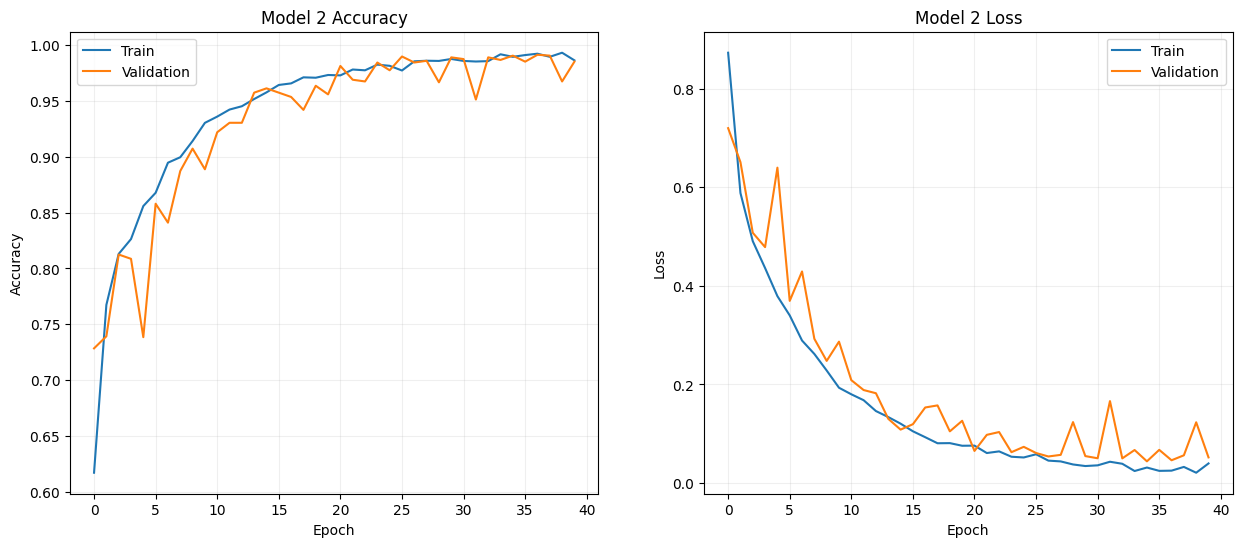

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

82/82 [==============================] - 3s 38ms/step


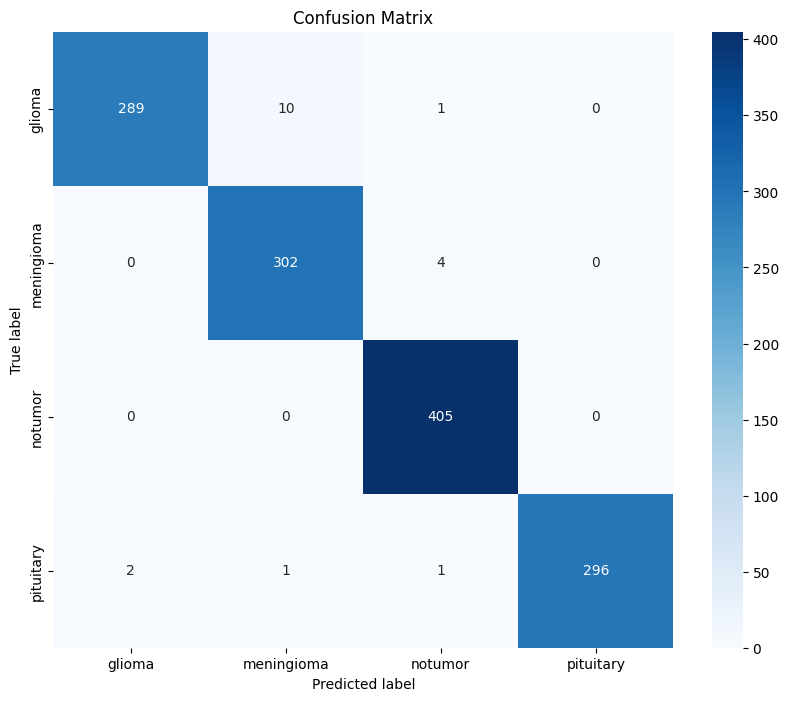

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.96      0.98       300
  meningioma       0.96      0.99      0.98       306
     notumor       0.99      1.00      0.99       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print classification report
print("Classification Report:\n", report)


In [ ]:


!pip show tensorflow


Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tf_keras, witwidget


In [ ]:
import keras

print(keras.__version__)


2024-04-29 06:06:23.577095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 06:06:23.577197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 06:06:23.701880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


3.2.1


In [ ]:
import tensorflow as tf

# Check the version of TensorFlow
print("TensorFlow version:", tf.__version__)

# Check the version of Keras (which is integrated into TensorFlow)
print("Keras version:", tf.keras.__version__)


TensorFlow version: 2.16.1


AttributeError: module 'tensorflow.keras' has no attribute '__version__'

In [ ]:
model.save('cnn_model.h5')

/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/input/mmmmmmmmmmmmmmmmmm/cnn_model.h5')


2024-04-28 16:19:51.799462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 16:19:51.799554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 16:19:51.912064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/input/mmmmmmmmmmmmmmmmmm/cnn_model.h5')

from PIL import Image
class_labels = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
import tensorflow as tf
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0004.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((255, 255))

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = model.predict(img_array)
for i, prob in enumerate(predictions[0]):
    print(f"Probability of {class_labels[i]}: {prob}")

1/1 [==============================] - 11s 11s/step
Probability of glioma: 0.0
Probability of meningioma: 0.0
Probability of notumor: 1.0
Probability of pituitary: 0.0


In [ ]:
!pip show tensorflow



Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tf_keras, witwidget


In [ ]:
!pip show keras

Name: keras
Version: 3.2.1
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: keras-tuner, tensorflow


In [ ]:

!pip show Pillow


Name: Pillow
Version: 9.5.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Jeffrey A. Clark (Alex)
Author-email: aclark@aclark.net
License: HPND
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: bokeh, contextily, datashader, easyocr, fastai, fury, ImageHash, imageio, imgaug, ipyvolume, matplotlib, openslide-python, pdf2image, pytesseract, scikit-image, torchvision, vaex-viz, wordcloud


In [ ]:
with open('requirements.txt', 'w') as f:
    for line in packages.split('\n'):
        package_info = line.split('==')
        if len(package_info) > 1:
            f.write(f"{package_info[0]}=={package_info[1]}\n")
        else:
            f.write(f"{package_info[0]}\n")


NameError: name 'packages' is not defined

In [ ]:
!pip install pipreqsnb

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 12.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 2.7 MB/s eta 0:00:00
  Created wheel for pipreqsnb: filename=pipreqsnb-0.2.4-py3-none-any.whl size=4126 sha256=00c78c1cfb1fbefde6b5d522b61382918c8b09144a8f55d16f003311215e00f5
  Stored in directory: /root/.cache/pip/wheels/c3/1b/47/ca78a979321cb4bf9e812da5157fb754712f43d094bc60bf61
Successfully built pipreqsnb
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: ipython
    Found existing installation: ipython 8.20.0
    Uninstalling ipython-8.20.0:
      Successfully uninstalled ipython-8.20.0
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.4.5
    Uninstalling nbco

In [ ]:
!pipreqsnb "/kaggle/working/"

pipreqs  /kaggle/working/
